# Exploring the cryptocurrency market

<strong>Note</strong>: To run this project you need API key on the <a href='https://coinmarketcap.com/'>CoinMarketCap</a>

In [1]:
import urllib.request as request
import json
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
import config

api_key = config.get_api_key('coinmarketcap')

In [3]:
url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest?CMC_PRO_API_KEY='+api_key+'&limit=5000'
with request.urlopen(url) as url_req:
    data = json.loads(url_req.read().decode())

In [4]:
all_ticks = pd.DataFrame(data['data'])

In [5]:
all_ticks.head()

,circulating_supply,cmc_rank,date_added,id,last_updated,max_supply,name,num_market_pairs,platform,quote,slug,symbol,tags,total_supply
0,1.820498e+07,1,2013-04-28T00:00:00.000Z,1,2020-02-07T17:07:38.000Z,2.100000e+07,Bitcoin,7681,None,"{'USD': {'price': 9783.7820568, 'volume_24h': ...",bitcoin,BTC,[mineable],1.820498e+07
1,1.096030e+08,2,2015-08-07T00:00:00.000Z,1027,2020-02-07T17:08:25.000Z,NaN,Ethereum,5144,None,"{'USD': {'price': 220.912129564, 'volume_24h':...",ethereum,ETH,[mineable],1.096030e+08
2,4.369822e+10,3,2013-08-04T00:00:00.000Z,52,2020-02-07T17:08:05.000Z,1.000000e+11,XRP,488,None,"{'USD': {'price': 0.279511878609, 'volume_24h'...",xrp,XRP,[],9.999109e+10
3,1.826590e+07,4,2017-07-23T00:00:00.000Z,1831,2020-02-07T17:08:07.000Z,2.100000e+07,Bitcoin Cash,422,None,"{'USD': {'price': 435.625102737, 'volume_24h':...",bitcoin-cash,BCH,[mineable],1.826590e+07
4,1.826305e+07,5,2018-11-09T00:00:00.000Z,3602,2020-02-07T17:08:10.000Z,2.100000e+07,Bitcoin SV,155,None,"{'USD': {'price': 293.364132104, 'volume_24h':...",bitcoin-sv,BSV,[mineable],1.826305e+07


In [19]:
def get_quote(row, col_name: str):
    col_value = row['quote']['USD'][col_name]
    return col_value

In [20]:
all_ticks['market_cap_usd'] = all_ticks.apply(get_quote, axis=1, args=['market_cap'])

In [8]:
# Selecting the 'id' and the 'market_cap_usd' columns
market_cap_raw = all_ticks.loc[:, ['slug', 'market_cap_usd']]

In [9]:
market_cap_raw.count()

slug              2397
market_cap_usd    2010
dtype: int64

The cryptocurrencies with NaN value are of little interest to us, so they are safe to remove.

In [10]:
# Filtering out rows without a market capitalisation
cap = market_cap_raw.query('market_cap_usd > 0')

In [11]:
cap.count()

slug              2010
market_cap_usd    2010
dtype: int64

## How big is Ethereum compared with the rest of cryptocurrencies?
Let's plot the market capitalization for the top 10 coins as the barplot to better visualize this. 

In [57]:
# Selecting the first 10 rows and setting the index
cap10 = cap[:10].set_index('slug')

# Calculating market_cap_perc
total_market_cap = cap.market_cap_usd.sum()
cap10 = cap10.assign(market_cap_perc=lambda x: x / total_market_cap * 100)

Text(0, 0.5, '% of total cap')

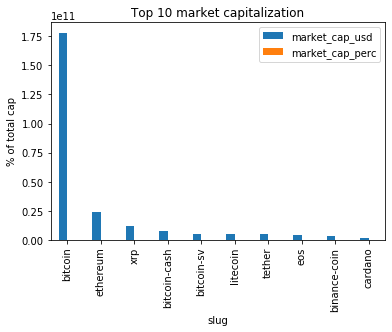

In [58]:
# Plotting the bar plot
ax = cap10.plot.bar(title='Top 10 market capitalization')
ax.set_ylabel('% of total cap')

### Making the plot easier to read and more informative
Bitcoin is too big and other coins are hard to distinguish. Let's use a log<sup>10</sup> scale of the 'raw' capitalization and different colors.

Text(0.5, 0, '')

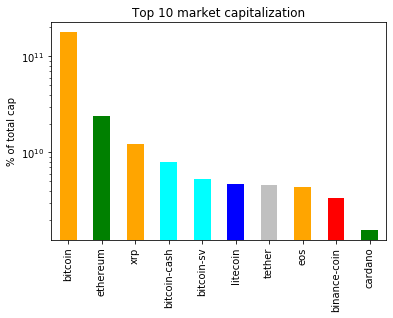

In [59]:
COLORS = ['orange', 'green', 'orange', 'cyan', 'cyan', 'blue', 'silver', 'orange', 'red', 'green']

ax = cap10['market_cap_usd'].plot.bar(title='Top 10 market capitalization', logy=True, color=COLORS)
ax.set_ylabel('% of total cap')
ax.set_xlabel('')

### Analizing volatility
Let's select and plot the 24 hours and 7 days percentage change.

In [60]:
volatility = all_ticks.loc[:, ['slug', 'quote']]
volatility['percent_change_24h'] = volatility.apply(get_quote, axis=1, args=['percent_change_24h'])
volatility['percent_change_7d'] = volatility.apply(get_quote, axis=1, args=['percent_change_7d'])
volatility = volatility.drop('quote', axis=1)

In [61]:
volatility = volatility.set_index('slug').dropna()

In [62]:
volatility = volatility.sort_values('percent_change_24h')

In [63]:
volatility.head()

,percent_change_24h,percent_change_7d
slug,,
win-coin,-97.0179,-97.1660
tcoin,-78.8560,-76.5553
lomocoin,-74.9796,-58.7612
999-coin,-71.3328,-91.8786
mainstream-for-the-underground,-70.7345,-61.4003


It seems we can loose a lot of money on cryptocurrencies. Let's plot the top 10 biggest gainers and the top 10 losers in market capitalization.

In [64]:
#Defining a function with 2 parameters, the series to plot and the title
def top10_subplot(volatility_series, title: str):
    # Making the subplot and the figure for two side by side plots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    
    # Plotting the barchart for the top 10 losers
    ax = volatility_series[:10].plot.bar(ax=axes[0], color='darkred')
    
    fig.suptitle(title)
    ax.set_ylabel('% change')
    
    # Plotting the barchart for the top 10 winners
    ax = volatility_series[-10:].plot.bar(ax=axes[1], color='darkblue')
    
    return fig, ax

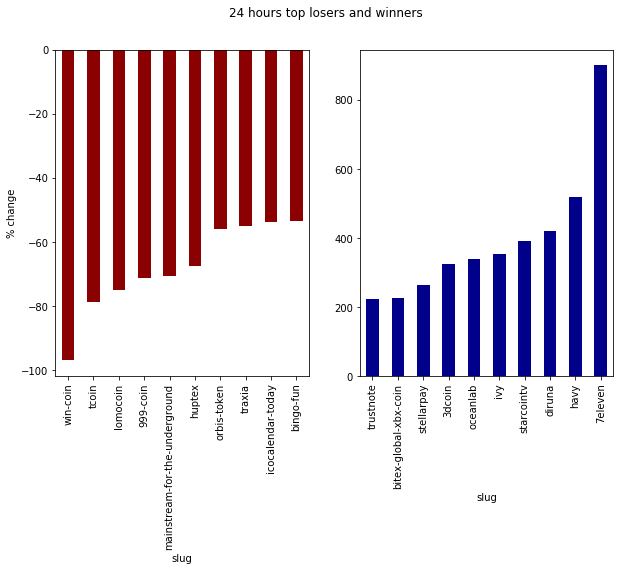

In [65]:
DTITLE = "24 hours top losers and winners"
fig, ax = top10_subplot(volatility['percent_change_24h'], DTITLE)

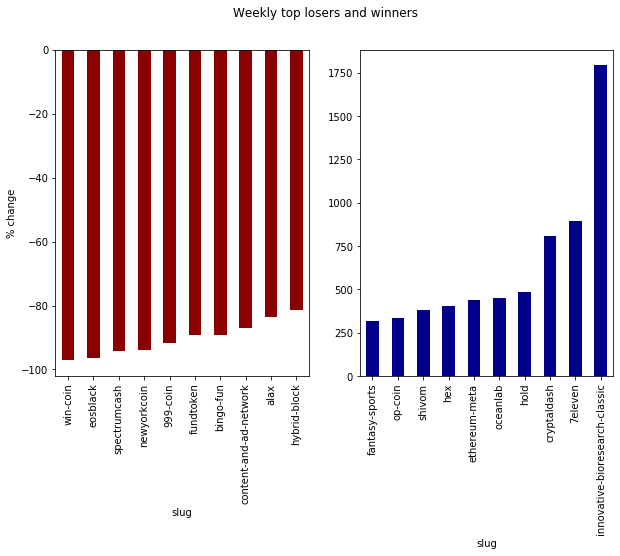

In [66]:
volatility7d = volatility.sort_values('percent_change_7d')
WTITLE = "Weekly top losers and winners"
fig, ax = top10_subplot(volatility7d['percent_change_7d'], WTITLE)

### Lage Cap coins.

In [73]:
largecaps = cap.query('market_cap_usd >= 10 ** 10')
print(largecaps)

       slug  market_cap_usd
0   bitcoin    1.781135e+11
1  ethereum    2.421264e+10
2       xrp    1.221417e+10


### All groups of Cap
<p>
    <li>Large cap: +10 billion</li>
    <li>Mid cap: 2 billion - 10 billion</li>
    <li>Small cap: 300 million - 2 billion</li>
    <li>Micro cap: 50 million - 300 million</li>
    <li>Nano cap: Below 50 million</li>
</p>
As Nano cap is too large let's group Large, Mid and Small cap coins into a group called Biggish.

In [68]:
# Counting different marketcaps from the "cap" DataFrame
def capcount(query_string: str) -> int:
    return cap.query(query_string).count().slug

<BarContainer object of 3 artists>

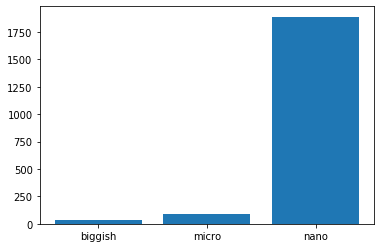

In [70]:
LABELS = ['biggish', 'micro', 'nano']

biggish = capcount('market_cap_usd >= 10 ** 6 * 300')
micro = capcount('market_cap_usd >= 10 ** 6 * 50 & market_cap_usd < 10 ** 6 * 300')
nano =  capcount('market_cap_usd < 10 ** 6 * 50')

values = [biggish, micro, nano]

plt.bar([0, 1, 2], values, tick_label=LABELS)